In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import pytorch_lightning as pl

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', -1)

from datasets import PlantCLEF2022Supr, PlantCLEF2022_Dataset


C:\Users\maeot\AppData\Local\Temp/ipykernel_7984/3718344470.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [17]:
columns = ["classid", "classid", "image_path", "species", "genus", "family"]
# df_web = pd.read_csv("web/PlantCLEF2022_web_training_metadata.csv", sep=";", usecols=columns)
df_trusted = pd.read_csv("trusted/PlantCLEF2022_trusted_training_metadata.csv", sep=";", usecols=columns)

In [18]:
df_trusted.head()

,classid,image_path,species,genus,family
0,2683260,2683260/d0749fe4f8ade13dd9402b0f43bc29e8f28af27a.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
1,2683260,2683260/7549c8ddadd95d996e10aa76f8e39bedb059c637.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
2,2683260,2683260/8c6049ebdff482b901f32e0ac9e421c69bc652b4.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
3,2683260,2683260/b932fd8619c667a5b4f3c38596911937a2692b26.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
4,2683260,2683260/9f9dbdb0b9ce8bc3fb562f648af7717b5511b597.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae


In [19]:
df_trusted.shape

(2886761, 5)

In [20]:
df_trusted.classid.nunique(),  df_trusted.species.nunique(), df_trusted.genus.nunique(), df_trusted.family.nunique()

(80000, 80000, 9603, 483)


# Supervised
    

## Data preparation

In [21]:
args = {}
args['description'] = 'PyTorch Supr'
args['epochs'] = 10
args['batch_size'] = 56
args['lr'] = 0.0003
args['weight_decay'] = 1e-4
args['out_dim'] = 128 
args['log_every_n_steps'] = 10
args['temperature'] = 0.07
args['n_views'] = 2
args['arch'] = 'resnet50'
args['seed'] = None
args['fp16_precision'] = True
args['checkpoints'] = "supr_checkpoints"
args['num_workers'] = 4
args['chekpoint_point'] = "selfsupr_checkpoints/selfsupr-epoch=25-selfsupr_train_loss=0.64-selfsupr_train_acc_top1=78.12.ckpt"

In [22]:
transform = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                               ])
ds = PlantCLEF2022Supr(df_trusted, root="C:\\Users\\maeot\\Documents\\code\\biomachina\\trusted\\images\\", 
                           label_col="species", filename_col="image_path", transform=transform)
ds

Dataset PlantCLEF2022Supr
    Number of datapoints: 62207
    Root Location: C:\Users\maeot\Documents\code\biomachina\trusted\images\
    Transforms (if any): Compose(
                             Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=None)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )

In [23]:
ds.class_size

2109

### Visualize sample

In [24]:
loader = torch.utils.data.DataLoader(ds, batch_size=args['batch_size'], shuffle=True, drop_last=True, num_workers=args['num_workers'], persistent_workers=True)
dataiter = iter(loader)
images, labels = dataiter.next() #images = list with 2 tensors of (B, C, H, W)
images.shape, labels

(torch.Size([56, 3, 224, 224]),
 tensor([1762, 1039,  429, 2050, 2070, 2018, 1401,   36,  128, 1084, 1895,  629,
         2031,  729,  710,  876,  339,  165, 2074,  941,  182,  488,  947, 1716,
          867,  179,   11, 1832, 1753,  333,  426, 1397,  796,  504, 1469, 1133,
          340, 1566, 1966,  988,  421,  760,  740,  567,  570, 1979,  484,   33,
         1644, 1514,  939,  141,  959,  628, 1583,  548]))

In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


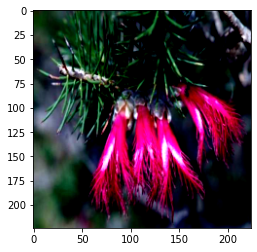

In [26]:
imshow(images[0])

## Training

In [27]:
from engines import SuprEngine, SimCLREngine
from models import ResNetSelfSupr, ResNetClassifier

selfsupr_model = ResNetSelfSupr(base_model=args['arch'], out_dim=args['out_dim'])
# selfsupr_engine = SimCLREngine.load_from_checkpoint(args['chekpoint_point'], model=selfsupr_model, loader=None, args=args)

model = ResNetClassifier(selfsupr_model, feature_dim=args['out_dim'], class_dim=ds.class_size)
engine = SuprEngine(model=model, loader=loader, args=args)


In [28]:
from pytorch_lightning.callbacks import ModelCheckpoint

SAVE_X_TIMES_PER_EPOCH = 0.1

checkpoint_callback = ModelCheckpoint(
        monitor="supr_train_loss", 
        dirpath=args["checkpoints"], 
        save_top_k=2, 
        mode="min",
        filename="supr-{epoch}-{supr_train_loss:.2f}-{supr_train_acc_top1:.2f}",
        save_on_train_epoch_end = True,
        every_n_train_steps = int((len(ds) / args['batch_size']) * SAVE_X_TIMES_PER_EPOCH)
)

In [29]:
trainer = pl.Trainer(gpus=1, num_nodes=1, 
                     precision=16, limit_train_batches=0.5, 
                     callbacks=[checkpoint_callback])
trainer.fit(engine, loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNetClassifier | 28.2 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
28.2 M    Trainable params
0         Non-trainable params
28.2 M    Total params
56.477    Total estimated model params size (MB)
C:\Users\maeot\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\maeot\Documents\code\biomachina\supr_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

C:\Users\maeot\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
